In [246]:
import pandas as pd
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc,f1_score
from sklearn.metrics import f1_score,precision_score,recall_score,confusion_matrix,classification_report,plot_confusion_matrix

In [2]:
df = pd.read_csv('industrial-security-clearance-decisions.csv')
df.dropna(inplace = True)
df.reset_index(inplace = True)
df.drop(['Unnamed: 0','index'],axis = 1,inplace = True)
df.sample()

,casenum,date,digest,keywords
15128,04-12681.h1,09/29/2006,"\t Applicant, who is a U.S. naturalized citiz...",Foreign Preference; Foreign Influence


In [239]:
df['casenum'].value_counts()

h1             57
05-14192.h1     2
04-08547.h1     2
02-11272.h1     2
04-11414.h1     2
               ..
11-03507.h1     1
08-06795.h1     1
09-03022.h1     1
10-00793.h1     1
96-0103.h1      1
Name: casenum, Length: 21197, dtype: int64

In [237]:
df['keywords'].value_counts()

Financial                                                            6460
Financial; Personal Conduct                                          1512
Foreign Influence                                                    1479
Guideline F                                                           950
Foreign Preference; Foreign Influence                                 609
                                                                     ... 
Alcohol Consumption, Sexual Behavior, Personal Conduct                  1
Use of Information Technology; Personal Financial                       1
Alcohol, Financial, Personal Conduct                                    1
Guideline b; Guideline F                                                1
Drugs; Personal Conduct; Criminal Conduct; Information Technology       1
Name: keywords, Length: 1156, dtype: int64

# **CASENUM,KEYWORDS and date don't seem to be useful as they have too many categories and  if used as source columns for model, it might lead to high dimensionality.so, We go ahead with digest textual data to create categories out of it and also to predict the classes**

# **Extracting useful info from Digest  and preprocessing**

In [3]:
a =[ df.loc[i]['digest'].replace(df.loc[i]['casenum'],'').split('.')[-2]  if len(df.loc[i]['digest'].replace(df.loc[i]['casenum'],'').split('.')) >2 else 'not available' for i in range(len(df))  ]

In [4]:
df['extracted_digest'] = a

In [ ]:
df

,casenum,date,digest,keywords,extracted_digest
0,15-08250.a1,07/28/2017,The Judge’s adverse findings under Guideline C...,Guideline C; Guideline B,Adverse decision affirmed
1,15-03801.a1,07/28/2017,Applicant argues that the Judge improperly foc...,Guideline B,Adverse decision affirmed
2,15-07971.a1,07/26/2017,Applicant’s appeal brief contains no assertion...,Guideline F,Adverse decision affirmed
3,15-03098.a1,07/26/2017,The Board cannot consider Applicant’s new evid...,Guideline F,Adverse decision affirmed
4,14-04693.a1,07/26/2017,Applicant contends that his financial record d...,Guideline F; Guideline E,Adverse decision affirmed
...,...,...,...,...,...
21333,96-0385.h1,11/07/1996,\t Applicant had used marijuana with varying ...,Drugs; Personal Conduct; Criminal Conduct,Clearance is denied
21334,96-0177.h1,11/07/1996,"\t The Applicant has filed, in an untimely fa...",Criminal Conduct,Clearance Granted
21335,96-0376.h1,11/05/1996,\t While Applicant's drug abuse was mitigated...,Drugs; Personal Conduct; Criminal Conduct,Clearance denied
21336,96-0245.h1,11/05/1996,\t drug involvement included dated use of mus...,Drugs; Personal Conduct; Criminal Conduct; Fin...,Clearance denied


In [ ]:
df['extracted_digest'].sample(10)

5670                             Adverse decision affirmed
20402                                 Clearance is granted
2176                                     Clearance granted
10645                                  Clearance is denied
9690                                         not available
12313                                  Clearance is denied
16435                                  Clearance is denied
10116                                  Clearance is denied
2183                                   Clearance is denied
14027     Eligibility for an ADP I/II/III position is g...
Name: extracted_digest, dtype: object

# **Removing Stop Words**

In [11]:
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')
stopwords_list = stopwords.words('english')

In [248]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [124]:
a2 = [' '.join([j.lower() for  j in i.replace('sensitive','classified').replace('denied','denied ').split(' ') if (j not in stopwords_list) and len(j) >1 ]) for i in df['extracted_digest']]

In [127]:
keywords_list = pd.Series(' '.join(a2).split(' ')).value_counts()[0:20]

In [128]:
keywords_list

clearance      14381
denied         10882
granted         6344
eligibility     3239
decision        3187
adverse         2763
affirmed        2734
classified      2218
access          2114
information     2100
security         921
position         558
favorable        412
trust            334
reversed         284
public           254
applicant's      251
available        251
request          240
case             226
dtype: int64

In [129]:
a3 = [' '.join([j for j in i.split() if (j in  keywords_list)  and j not in stopwords_list ]) for i in a2]
len(a3)

21338

In [156]:
z = pd.Series([i if len(i.split(' '))>1 else 'not_enough_keywords' for i in a3 ])
z

0        adverse decision affirmed
1        adverse decision affirmed
2        adverse decision affirmed
3        adverse decision affirmed
4        adverse decision affirmed
                   ...            
21333             clearance denied
21334            clearance granted
21335             clearance denied
21336             clearance denied
21337             clearance denied
Length: 21338, dtype: object

# **Top 20 most occuring classes** 

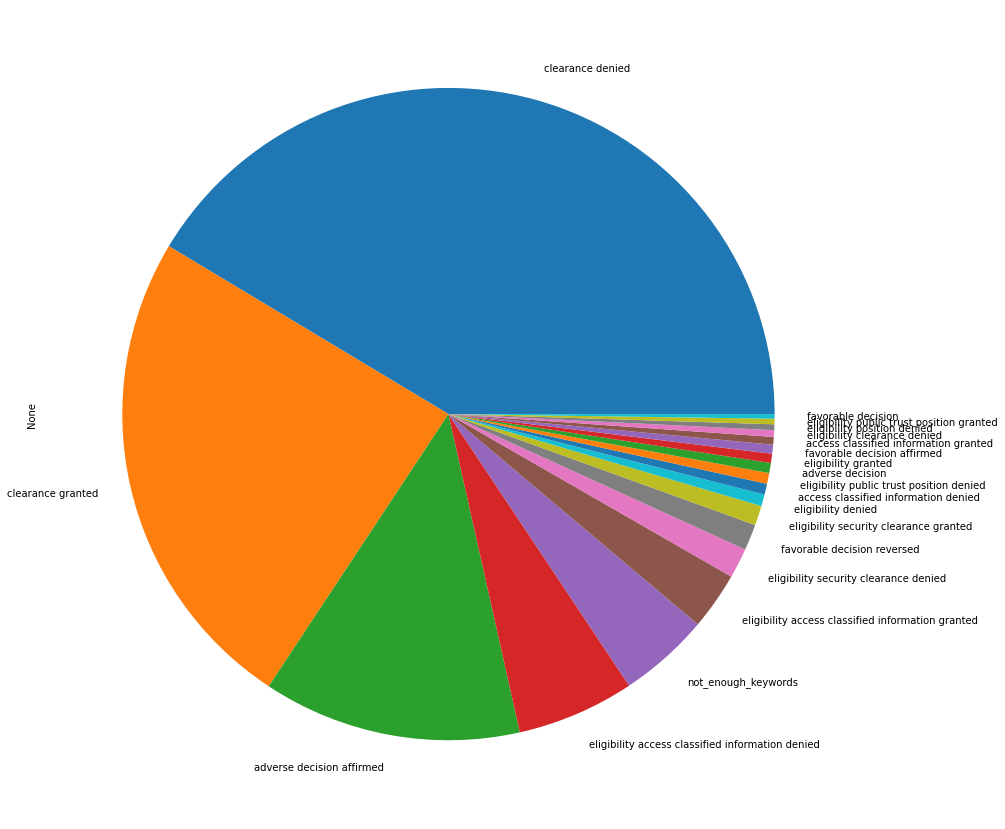

In [243]:
plt.figure(figsize = (20,15))
z.value_counts().sort_values(ascending = False)[0:20].plot(kind = 'pie')

In [170]:
z.value_counts().sort_values(ascending = False)[0:25]

clearance denied                                      8482
clearance granted                                     4983
adverse decision affirmed                             2623
eligibility access classified information denied      1195
not_enough_keywords                                    924
eligibility access classified information granted      583
eligibility security clearance denied                  305
favorable decision reversed                            264
eligibility security clearance granted                 200
eligibility denied                                     119
access classified information denied                   110
eligibility public trust position denied               110
adverse decision                                       102
eligibility granted                                     93
favorable decision affirmed                             91
access classified information granted                   78
eligibility clearance denied                            

# Mapping classes with similar meaning to one class

In [192]:
word_mappings = {'eligibility security': 'security',
                 'eligibility clearance':'clearance',
                 'eligibility access': 'access',
                 'eligibility position': 'position',
                 'eligibility public': 'public',
                 'request security': 'security',
                 }

In [193]:
new_classes = []
for  i in z:
  for j in word_mappings.keys():
    if j in i:
      #print(i,'-------',j,'----------',i.replace(j,word_mappings[j]))
      i = i.replace(j,word_mappings[j])
    else:
      pass
  new_classes.append(i)
pd.Series(new_classes).value_counts().sort_values(ascending = False)[0:20]

clearance denied                                      8550
clearance granted                                     5010
adverse decision affirmed                             2623
access classified information denied                  1305
not_enough_keywords                                    924
access classified information granted                  661
security clearance denied                              370
security clearance granted                             268
favorable decision reversed                            264
eligibility denied                                     119
public trust position denied                           118
adverse decision                                       102
eligibility granted                                     93
favorable decision affirmed                             91
position denied                                         59
public trust position granted                           56
favorable decision                                      

In [206]:
value_countings = pd.Series(new_classes).value_counts().sort_values()

In [196]:
df

,casenum,date,digest,keywords,extracted_digest,new_classes
0,15-08250.a1,07/28/2017,The Judge’s adverse findings under Guideline C...,Guideline C; Guideline B,Adverse decision affirmed,adverse decision affirmed
1,15-03801.a1,07/28/2017,Applicant argues that the Judge improperly foc...,Guideline B,Adverse decision affirmed,adverse decision affirmed
2,15-07971.a1,07/26/2017,Applicant’s appeal brief contains no assertion...,Guideline F,Adverse decision affirmed,adverse decision affirmed
3,15-03098.a1,07/26/2017,The Board cannot consider Applicant’s new evid...,Guideline F,Adverse decision affirmed,adverse decision affirmed
4,14-04693.a1,07/26/2017,Applicant contends that his financial record d...,Guideline F; Guideline E,Adverse decision affirmed,adverse decision affirmed
...,...,...,...,...,...,...
21333,96-0385.h1,11/07/1996,\t Applicant had used marijuana with varying ...,Drugs; Personal Conduct; Criminal Conduct,Clearance is denied,clearance denied
21334,96-0177.h1,11/07/1996,"\t The Applicant has filed, in an untimely fa...",Criminal Conduct,Clearance Granted,clearance granted
21335,96-0376.h1,11/05/1996,\t While Applicant's drug abuse was mitigated...,Drugs; Personal Conduct; Criminal Conduct,Clearance denied,clearance denied
21336,96-0245.h1,11/05/1996,\t drug involvement included dated use of mus...,Drugs; Personal Conduct; Criminal Conduct; Fin...,Clearance denied,clearance denied


In [210]:
df['filter'] = [value_countings[i] for i in df['new_classes']]

# Filtering out classes occuring rarely

In [213]:
filtered_df = df[df['filter']>=40]

<BarContainer object of 2 artists>

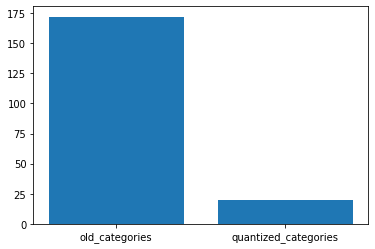

In [259]:
plt.bar(x = ['old_categories','quantized_categories'],height =[len(df['new_classes'].unique()),len(filtered_df['new_classes'].unique())])

# **Word cloud**

In [231]:
digest_list = [i for i in filtered_df['new_classes']]
words = ' '.join([i for word in digest_list for i in word.split()])

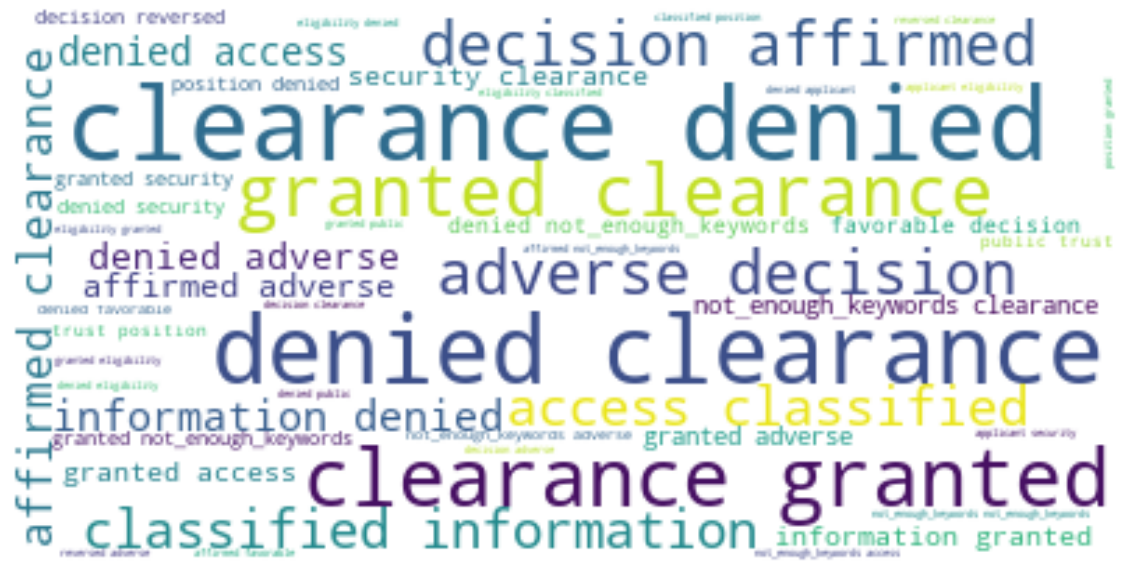

In [232]:
wordcloud_review_text = WordCloud(background_color="white").generate(words)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud_review_text, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Using  COUNT VECTORIZATION to use the teh extracted digest as predictor** 

In [214]:
from sklearn.feature_extraction.text import CountVectorizer

In [216]:
cv = CountVectorizer(max_features=7000,ngram_range=(1,2),stop_words= set(stopwords_list))

In [218]:
y_cv = filtered_df['new_classes']

In [219]:
x_cv = cv.fit_transform(filtered_df['extracted_digest']).toarray()

# **Train and Test the Model**

In [221]:
X_cv_train,X_cv_test,y_cv_train,y_cv_test=train_test_split(x_cv,y_cv,test_size=0.2,random_state=42)

In [222]:
model = DecisionTreeClassifier()
model.fit(X_cv_train,y_cv_train)
model.score(X_cv_test,y_cv_test)

0.9983160933365408

[[ 233    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0  119    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0   15    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0  512    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0   12    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    9    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    0 1738    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    0    0 1038    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0   19    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0   18    

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 1080x720 with 0 Axes>

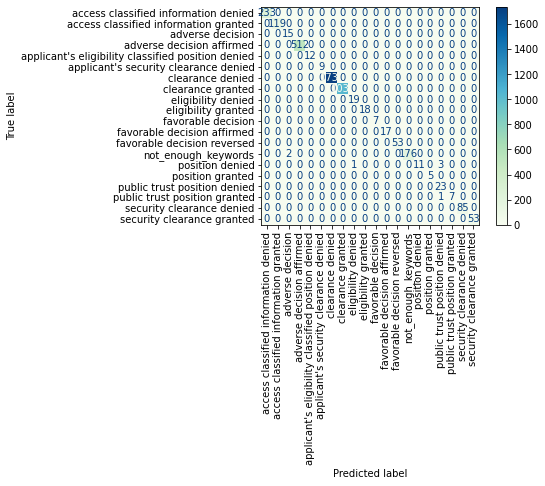

--------------------------------------------------
                                                    precision    recall  f1-score   support

              access classified information denied       1.00      1.00      1.00       233
             access classified information granted       1.00      1.00      1.00       119
                                  adverse decision       0.88      1.00      0.94        15
                         adverse decision affirmed       1.00      1.00      1.00       512
applicant's eligibility classified position denied       1.00      1.00      1.00        12
             applicant's security clearance denied       1.00      1.00      1.00         9
                                  clearance denied       1.00      1.00      1.00      1738
                                 clearance granted       1.00      1.00      1.00      1038
                                eligibility denied       0.95      1.00      0.97        19
                            

In [234]:
predicted_lr_cv_test = model.predict(X_cv_test)
print(confusion_matrix(y_cv_test,predicted_lr_cv_test))
print("-"*50)
plt.figure(figsize = (15,10))
plot_confusion_matrix(model,X_cv_test,y_cv_test, cmap = "GnBu",xticks_rotation='vertical')
plt.show()
print("-"*50)
print(classification_report(y_cv_test,predicted_lr_cv_test))